--- 
<center><h4>IMPORTS</h4></center>

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import math
from shapely.geometry import Point, LineString, Polygon
import random

--- 
<center><h4>SIMULATION LIBRARY</h4></center>

---

In [3]:
def generate_lidar_scan(sensor_position, obstacles, num_beams, max_range, scan_angle):
    """
    Generates an artificial 2D LiDAR scan.
    
    :param sensor_position: Tuple (x, y) representing the position of the LiDAR sensor.
    :param obstacles: List of tuples ((x1, y1), (x2, y2)) representing line segments as obstacles.
    :param num_beams: Number of LiDAR beams.
    :param max_range: Maximum range of the LiDAR.
    :param scan_angle: Angle range of the scan in degrees.
    :return: Numpy array of distances for each beam and angles.
    """
    angles = np.linspace(0, scan_angle * np.pi / 180, num_beams, endpoint=False)  # Angles for the scan.
    distances = np.full(num_beams, max_range)  # Initialize distances with the maximum range.
    
    for i, angle in enumerate(angles):
        direction = (math.cos(angle), math.sin(angle))
        beam_endpoint = (sensor_position[0] + direction[0] * max_range,
                         sensor_position[1] + direction[1] * max_range)
        
        for obstacle in obstacles:
            intersection_point = ray_segment_intersection(sensor_position, angle, obstacle[0], obstacle[1], max_range)
            if intersection_point is not None:
                distance = np.linalg.norm(np.array(sensor_position) - np.array(intersection_point))
                if distance < distances[i]:
                    distances[i] = distance
    
    return distances, angles

def ray_segment_intersection(p, theta, q, d, max_range):
    """
    Checks the intersection of a ray with a line segment.
    
    :param p: The origin point of the ray (x_p, y_p).
    :param theta: The angle of the ray in radians.
    :param q: Starting point of the line segment (x1, y1).
    :param d: Ending point of the line segment (x2, y2).
    :param max_range: Maximum range of the LiDAR.
    :return: Intersection point if within the segment and range, otherwise None.
    """
    # Define the endpoint of the ray
    ray_endpoint = (p[0] + max_range * np.cos(theta), p[1] + max_range * np.sin(theta))

    # Create LineString objects for the ray and the segment
    ray_line = LineString([p, ray_endpoint])
    segment_line = LineString([q, d])

    # Check for intersection
    intersection = ray_line.intersection(segment_line)

    # Validate the intersection point
    if intersection.is_empty or not intersection.is_simple or not intersection.geom_type == 'Point':
        return None

    intersection_point = (intersection.x, intersection.y)
    distance = np.linalg.norm(np.array(p) - np.array(intersection_point))

    return intersection_point if distance <= max_range else None

def generate_random_polygons(warehouse, num_obstacles, num_sides, radius, min_distance_from_origin):
    """
    Generates random polygons within the warehouse bounds.
    
    :param warehouse: List of tuples defining the warehouse boundary.
    :param num_obstacles: Number of random obstacles to generate.
    :param num_sides: Number of sides for each polygon.
    :param radius: Radius of each polygon.
    :param min_distance_from_origin: Minimum distance from the origin for obstacles.
    :return: List of line segments representing the obstacles.
    """
    warehouse_length = warehouse[0][0][1]
    warehouse_width = warehouse[0][1][0] - warehouse[1][0][0]
    x_min, x_max = warehouse[1][0][0], warehouse[0][1][0]
    y_min, y_max = -warehouse_length, warehouse_length
    
    def generate_polygon(center, radius, num_sides, rotation):
        angle = 2 * math.pi / num_sides
        return [(center[0] + radius * math.cos(i * angle + rotation), 
                 center[1] + radius * math.sin(i * angle + rotation)) for i in range(num_sides)]
    
    polygons = []
    remaining_obstacles = num_obstacles
    
    while remaining_obstacles > 0:
        for i in range(num_obstacles):
            while True:
                # Generate a random center for the polygon
                center_x = random.uniform(x_min, x_max)
                center_y = random.uniform(y_min, y_max)
                
                # Ensure the polygon is at least `min_distance_from_origin` from the origin
                if math.dist((center_x, center_y), (0, 0)) < min_distance_from_origin:
                    continue
                
                rotation = random.uniform(0, 2 * math.pi)  # Random rotation angle

                # Determine the number of sides
                sides = num_sides if remaining_obstacles == num_obstacles else random.randint(2, max(2, num_sides))

                polygon = generate_polygon((center_x, center_y), radius, sides, rotation)
                
                # Check that the polygon is within the warehouse boundary and does not overlap others
                if all(x_min <= x <= x_max and y_min <= y <= y_max for x, y in polygon):
                    if all(not any(math.dist(p, q) < radius for p in poly for q in polygon) for poly in polygons):
                        polygons.append(polygon)
                        remaining_obstacles -= 1
                        break
    
    # Convert polygons to line segments
    segments = []
    for polygon in polygons:
        for i in range(len(polygon)):
            segments.append((polygon[i], polygon[(i + 1) % len(polygon)]))
    
    return segments

def calculate_valid_points(distances, angles, sensor_position, max_range):
    """
    Calculate the valid points from LiDAR distances and angles.
    
    :param distances: Numpy array of distances.
    :param angles: Numpy array of angles.
    :param sensor_position: Tuple (x, y) representing the LiDAR sensor position.
    :param max_range: Maximum range of the LiDAR.
    :return: Numpy array of valid (x, y) points.
    """
    valid_points = []
    for distance, angle in zip(distances, angles):
        if distance < max_range:
            x = sensor_position[0] + distance * np.cos(angle)
            y = sensor_position[1] + distance * np.sin(angle)
            valid_points.append((x, y))
    points = np.array(valid_points)
    return points

def plot_lidar_scan(obstacles, distances, angles, sensor_position, max_range, points, warehouse_length, warehouse_width):
    """
    Plots the LiDAR scan with obstacles and detected points.
    
    :param obstacles: List of line segments representing obstacles.
    :param distances: Numpy array of distances from the LiDAR scan.
    :param angles: Numpy array of angles from the LiDAR scan.
    :param sensor_position: Tuple (x, y) representing the LiDAR sensor position.
    :param max_range: Maximum range of the LiDAR.
    :param points: Numpy array of valid (x, y) points.
    :param warehouse_length: Length of the warehouse.
    :param warehouse_width: Width of the warehouse.
    """
    plt.figure(figsize=(12, 12))

    # Plot obstacles
    for obstacle in obstacles:
        plt.plot([obstacle[0][0], obstacle[1][0]], [obstacle[0][1], obstacle[1][1]], 'k-')

    # Plot LiDAR scan lines
    for distance, angle in zip(distances, angles):
        end_x = sensor_position[0] + distance * np.cos(angle)
        end_y = sensor_position[1] + distance * np.sin(angle)
        if distance < max_range:
            plt.plot([sensor_position[0], end_x], [sensor_position[1], end_y], 'r-', alpha=0.5)
        else:
            plt.plot([sensor_position[0], end_x], [sensor_position[1], end_y], 'r:', alpha=0.3)

    # Plot valid points if available
    if points is not None and len(points) > 0:
        plt.scatter(points[:, 0], points[:, 1], c='g', s=10)

    # Plot sensor position with an image centered at (0, 0)
    frame = mpimg.imread("assets/frame.png")
    height, width, _ = frame.shape
    scale_factor = 400 * 20 / max(warehouse_length, warehouse_width)
    extent = (-width / (2 * scale_factor), width / (2 * scale_factor), -height / (2 * scale_factor), height / (2 * scale_factor))
    plt.imshow(frame, extent=extent, aspect='auto', zorder=10)
    plt.text(sensor_position[0] + 0.15, sensor_position[1] - 0.3, "LIDAR", fontsize=8, color='black', fontweight='bold')
    
    # Set plot limits and aspect ratio
    plot_limit = max(warehouse_length / 2 + 1, warehouse_width / 2 + 1)
    plt.xlim(-plot_limit, plot_limit)
    plt.ylim(-plot_limit, plot_limit)
    plt.gca().set_aspect('equal', adjustable='box')

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Synthetic 2D Lidar Simulated Scan')

    # Save the plot
    plt.savefig('assets/plot.png', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

--- 
<center><h4>PARAMS</h4></center>

---

##### SIMULATION PARAMS


In [4]:
# Dimensions of the warehouse
warehouse_length = 18  # Length of the warehouse
warehouse_width = 18  # Width of the warehouse

# Define the warehouse boundaries as line segments
warehouse = [
    ((-warehouse_width / 2, warehouse_length / 2), (warehouse_width / 2, warehouse_length / 2)),  # Top boundary
    ((-warehouse_width / 2, warehouse_length / 2), (-warehouse_width / 2, -warehouse_length / 2)),  # Left boundary
    ((warehouse_width / 2, warehouse_length / 2), (warehouse_width / 2, -warehouse_length / 2)),  # Right boundary
    ((-warehouse_width / 2, -warehouse_length / 2), (warehouse_width / 2, -warehouse_length / 2))  # Bottom boundary
]

num_obstacles = 10  # Number of obstacles to generate
num_sides = 5  # Minimum number of sides for each obstacle polygon

obstacles_radius = 0.8  # Radius of obstacles
min_distance_from_origin = 2  # Minimum distance from origin for obstacle placement

# Generate random polygons as obstacles within the warehouse
random_polygons_segments = generate_random_polygons(warehouse, num_obstacles, num_sides, obstacles_radius, min_distance_from_origin)
# Combine warehouse boundaries and generated obstacle segments
obstacles = warehouse + random_polygons_segments

sensor_position = (0, 0)  # Position of the LiDAR sensor for simulation

##### USE CASE PARAMS

In [5]:
num_beams = 360  # Determines how many beams (or rays) the LiDAR sensor will emit in a scan_angle.
max_range = 10.0  # Specifies the maximum distance up to which the LiDAR sensor can detect obstacles or objects. 
scan_angle = 360  # Defines the total angular range covered by the LiDAR sensor for scanning. 

--- 
<center><h4>OPERATING SIMULATION</h4></center>

---

##### LiDAR SCAN GENERATION

In [6]:
distances, angles = generate_lidar_scan(sensor_position, obstacles, num_beams, max_range, scan_angle)
# Filter out points that do not encounter obstacles
points = calculate_valid_points(distances, angles, sensor_position, max_range)

##### PLOT SIMULATION

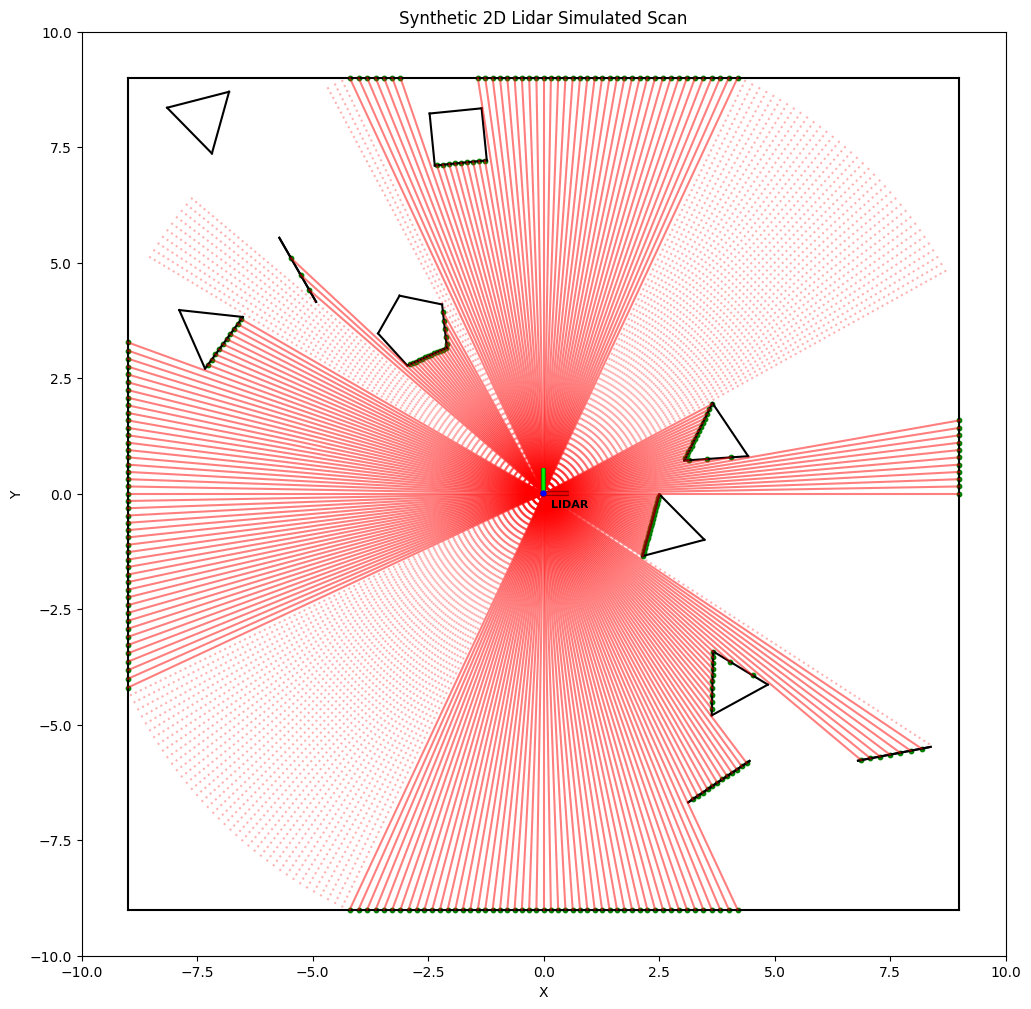

In [7]:
plot_lidar_scan(obstacles, distances, angles, sensor_position, max_range, points, warehouse_length, warehouse_width)